In [1]:
!pip install git+https://github.com/python-graphblas/python-graphblas

  Cloning https://github.com/python-graphblas/python-graphblas to /tmp/pip-req-build-uk1rwnvg
  Running command git clone --filter=blob:none --quiet https://github.com/python-graphblas/python-graphblas /tmp/pip-req-build-uk1rwnvg
  Resolved https://github.com/python-graphblas/python-graphblas to commit 27b23e414a9a73daa9c3dda9698e227562d9a18c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 17.6 MB/s eta 0:00:00
  Created wheel for python-graphblas: filename=python_graphblas-2024.2.0+2.g27b23e41-py3-none-any.whl size=351142 sha256=d6ec5effca7ae258981fedd6664d620ae4870dd3ab00c5bf126df963c07da035
  Stored in directory: /tmp/pip-ephem-wheel-cache-5xz9t67r/wheels/1d/ff/e1/7abbc85fde1376805d105bcb709a635cac5d6fcf1cc6f7d3ad
Successfully built python-graphblas


In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread

**MSBFS-Levels**

In [21]:
def MSBFS_Levels(A, vertex_cnt):
  #1.Проверка на ориентированность графа
  n = A.nrows #получаю общее количество вершин
  if A.isequal(A.T) and A.nvals>0: #проверяю, что граф неориентирован
    raise Exception("Ошибка: граф является неориентированным")
  #2.Задание начальных значений для параметров
  m = vertex_cnt.size #получаю количество строк массива (по количеству стартовых вершин)
  result = Matrix(dtypes.INT32, m, n) #задаю результирующую матрицу
  f = Matrix(bool, m, n) #задаю фронт
  succ = Vector(bool, m) #задаю вектор, определяющий доступность каких-либо вершин из текущей
  for i in range(m):
    f[i,vertex_cnt[i]] << True #заполняю изначальную матрицу строками (по одной на каждую стартовую вершину)
  level=0
  #3.Цикл обхода графа
  while True:
    result(mask=f.V) << level #заполняю стартовые вершины как нулевой уровень
    f(~result.S, replace=True) << f.mxm(A, semiring.lor_land) #рассчитываю следующий фронт (путем перемножения матриц и использования маски)
    for i in range(m):
      succ[i] << f[i,:].reduce(monoid.lor, allow_empty=False) #заполняю вектор наличия доступных вершин (для каждой из стартовых)
    #рассчитываю, когда остановить цикл (если ни из одной стартовой вершины на очередной итерации нет доступных вершин)
    cnt_true=0
    for i in range(m):
      if succ[i]:
        #если хотя бы один элемент True, дальше искать не имеет смысла
        cnt_true+=1
        break
    if cnt_true==0:
      break
    level+=1 #увеличиваю счетчик уровней
  #4.Приведение ответа к требуемому формату
  #заполняю недоступные вершины дефолтными значениями
  #преобразую полученный результат в указанный в условии формат: словарь, где ключ - номер вершины, значение - массив номеров уровней
  output = {}
  for i in range(m):
    ar_val=[]
    for j in range(n):
      if result[i,j].value is None:
        ar_val.append(-1)
      else:
        ar_val.append(result[i,j].value)
    output[vertex_cnt[i]]=np.array(ar_val)
  return output

**MSBFS-Parents**

In [15]:
def MSBFS_Parents(A, vertex_cnt):
  #1.Проверка на ориентированность графа
  N = A.nrows #получаю общее количество вершин
  if A.isequal(A.T) and A.nvals>0: #проверяю, что граф неориентирован
    raise Exception("Ошибка: граф является неориентированным")
  M = vertex_cnt.size
  #2.Задание стартовых значений
  #генерация матрицы, где идентификатор вершины равен значению
  index_ramp = Matrix(dtypes.UINT64, M, N)
  for i in range(M):
    for j in range(N):
      index_ramp[i,j] << j
  parents = Matrix(dtypes.UINT64, M, N)
  wavefront = Matrix(dtypes.UINT64, M, N)
  for i in range(M):
    parents[i,vertex_cnt[i]] << vertex_cnt[i] #заполняю изначальную матрицу строками (по номерам соответствующей вершины)
    wavefront[i, vertex_cnt[i]] << 1
  #3.Цикл обхода графа
  while wavefront.nvals > 0:
    wavefront << index_ramp.ewise_mult(wavefront, binary.first) #преобразуем все сохраненные значения в wavefront в их индекс
    wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.min_first) #маскирование родительского списка
    parents(binary.plus) << wavefront #Объединение новых родительских элементов в текущий волновой фронт с существующими родителями
  #4.Приведение ответа к требуемому формату
  #заполняю недоступные вершины дефолтными значениями
  #преобразую полученный результат в указанный в условии формат: словарь, где ключ - номер вершины, значение - массив родительских вершин
  output={}
  for i in range(M):
    ar_val=[]
    for j in range(N):
      if parents[i,j].value is None:
        ar_val.append(-2)
      elif j==vertex_cnt[i]:
        ar_val.append(-1)
      else:
        ar_val.append(parents[i,j].value)
    output[vertex_cnt[i]]=np.array(ar_val)
  return output

**Тестирование реализаций**

Далее будут представлены 3 графа для проверки корректности созданных реализаций. Они представляют собой 3 различных основных конфигурации: неориентированный граф, граф, где все вершины связаны между собой (но не обязательно достижимы из каждой стартовой точки) и граф, у которого вершины сгруппированы на несколько связанных кусков. Во втором и третьем кейсе сделааю так, чтобы были как достижимые, так и недостижимые вершины.

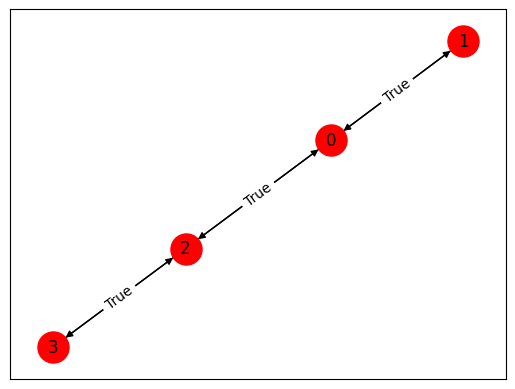

In [4]:
#Первым проверим поведение созданных функций на неориентированном графе (они должны вернуть ошибку)
M1=gb.Matrix.from_coo(
    [0,1,0,2,2,3],
    [1,0,2,0,3,2],
    [True,True,True,True,True,True],
    nrows=4,
    ncols=4
)
gb.viz.draw(M1)

In [17]:
print(MSBFS_Levels(M1, np.array([0,1,2,3])))

Exception: Ошибка: граф является неориентированным

In [16]:
print(MSBFS_Parents(M1, np.array([0,1])))

Exception: Ошибка: граф является неориентированным

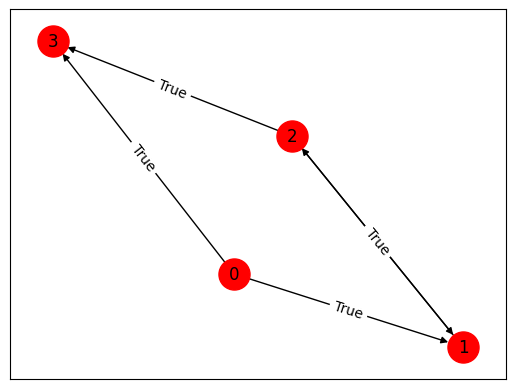

In [18]:
#Далее проверим граф, где все вершины связаны между собой
#для простоты проверки возьмем всего 4 вершины и 2 стартовых
M2=gb.Matrix.from_coo(
    [0,1,2,0,2],
    [1,2,1,3,3],
    [True,True,True,True,True],
    nrows=4,
    ncols=4
)
gb.viz.draw(M2)
#стартуем из вершин 0 и 2:
#для уровней:
#-для старта из 0: вершины 1 и 3 - 1го уровня, 2 - 2го уровня
#-для старта из 2: вершины 3 и 1 - 1го уровня, 0 - недостижима
assert (MSBFS_Levels(M2, np.array([0,2]))[0]==np.array([0, 1, 2, 1])).all()
assert (MSBFS_Levels(M2, np.array([0,2]))[2]==np.array([-1, 1, 0, 1])).all()
#для родителей:
#-для старта из 0: вершина 1 достижима из 0, 2 - из 1, 3 из 0 и 2 (ближайшая 0)
#-для старта из 2: вершины 3 и 1 достижимы из 2, 0 - недостижима в принципе
assert (MSBFS_Parents(M2, np.array([0,2]))[0]==np.array([-1, 0, 1, 0])).all()
assert (MSBFS_Parents(M2, np.array([0,2]))[2]==np.array([-2, 2, -1, 2])).all()

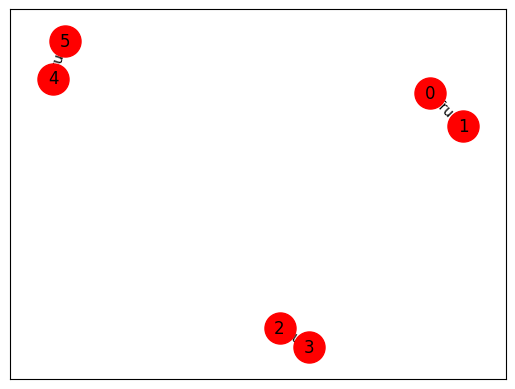

In [19]:
#Последним проверим граф, состоящих из трех связанных кусков
#для простоты проверки возьмем всего 6 вершин и 3 стартовых
M3=gb.Matrix.from_coo(
    [0,2,3,4,5],
    [1,3,2,5,4],
    [True,True,True,True,True],
    nrows=6,
    ncols=6
)
gb.viz.draw(M3)
#стартуем из вершин 0, 2 и 4
#для уровней:
#-здесь все аналогично: соседняя вершина - 1го уровня, остальные недостижимы
assert (MSBFS_Levels(M3, np.array([0,2,4]))[0]==np.array([0, 1, -1, -1, -1, -1])).all()
assert (MSBFS_Levels(M3, np.array([0,2,4]))[2]==np.array([-1, -1, 0, 1, -1, -1])).all()
assert (MSBFS_Levels(M3, np.array([0,2,4]))[4]==np.array([-1, -1, -1, -1, 0, 1])).all()
#для родителей:
#-здесь все такаже: соседняя достижима из стартовой, остальные недостижимы
assert (MSBFS_Parents(M3, np.array([0,2,4]))[0]==np.array([-1, 0, -2, -2, -2, -2])).all()
assert (MSBFS_Parents(M3, np.array([0,2,4]))[2]==np.array([-2, -2, -1, 2, -2, -2])).all()
assert (MSBFS_Parents(M3, np.array([0,2,4]))[4]==np.array([-2, -2, -2, -2, -1, 4])).all()

**Тестирование на реальных графах**

In [41]:
realGraph1=mmread('Harvard500.mtx')
realGraph2=mmread('Roget.mtx')
realGraph3=mmread('email-Eu-core.mtx')

In [27]:
#функция для выбора случайного количества стартовых вершин (по количеству вершин графа и проценту стартовых вершин)
def Generate_Vertex(nrows, cnt_vert):
  import random
  ar_vertex=range(nrows)
  vertex_ar=random.sample(ar_vertex, int(nrows*cnt_vert/100))
  return np.array(vertex_ar)


In [ ]:
#функция тестирования
#получаю время выполнения через timeit
def test_Levels_time(A, vertex_cnt):
  print('MSBFS_Levels:')
  %timeit MSBFS_Levels(A, vertex_cnt)

In [ ]:
#функция тестирования
#получаю время выполнения через timeit
def test_Parents_time(A, vertex_cnt):
  print('MSBFS_Parents:')
  %timeit MSBFS_Levels(A, vertex_cnt)

In [ ]:
graphAr=[realGraph1, realGraph2, realGraph3]
start_vert_perc=[10, 50, 90]
for i in graphAr:
  print(f'Количество вершин: {i.shape[0]}, количество ребер: {len(i.to_coo()[0])}')
  for j in start_vert_perc:
    print(f'Количество стартовых вершин: {int(j/100*i.nrows)}')
    print(test_Levels_time(i, Generate_Vertex(i.nrows, j)))

Количество вершин: 500, количество ребер: 2636
Количество стартовых вершин: 50
MSBFS_Levels:
2.53 s ± 1.16 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 250
MSBFS_Levels:
10.8 s ± 695 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 450
MSBFS_Levels:
19 s ± 544 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 1022, количество ребер: 5075
Количество стартовых вершин: 102
MSBFS_Levels:
9.79 s ± 227 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 511
MSBFS_Levels:
49.3 s ± 678 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 919
MSBFS_Levels:
1min 29s ± 2.41 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 1005, количество ребер: 25571
Количество стартовых вершин: 100
MSBFS_Levels:
8.84 s ± 591 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вер

In [ ]:
graphAr=[realGraph1, realGraph2, realGraph3]
start_vert_perc=[10, 50, 90]
for i in graphAr:
  print(f'Количество вершин: {i.shape[0]}, количество ребер: {len(i.to_coo()[0])}')
  for j in start_vert_perc:
    print(f'Количество стартовых вершин: {int(j/100*i.nrows)}')
    print(test_Parents_time(i, Generate_Vertex(i.nrows, j)))

Количество вершин: 500, количество ребер: 2636
Количество стартовых вершин: 50
MSBFS_Parents:
2.08 s ± 306 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 250
MSBFS_Parents:
10.6 s ± 644 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 450
MSBFS_Parents:
18.9 s ± 578 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 1022, количество ребер: 5075
Количество стартовых вершин: 102
MSBFS_Parents:
10.3 s ± 622 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 511
MSBFS_Parents:
49.1 s ± 556 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 919
MSBFS_Parents:
1min 28s ± 808 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 1005, количество ребер: 25571
Количество стартовых вершин: 100
MSBFS_Parents:
11.6 s ± 1.34 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стар

**Тестирование на случайных графах**


In [25]:
#функция генерации случайного неориентированного графа
def gen_random_graphs(rows, reber):
  import random
  #задаю множества, так как номера элементов уникальны
  set_vert=set()
  #создаю верхний треугольник матрицы смежности в формате множества
  for i in range(rows**2):
    if i//rows!=i%rows:
      set_vert.add(i)
  #выбираю случайные индексы вершин старта и конца для создания ребер согласно входному параметру
  x_from=random.sample(set_vert, reber)
  indices_from=[]
  indices_to=[]

  for i in x_from:
    indices_from.append(i//rows)
    indices_to.append(i%rows)

  return gb.Matrix.from_coo(
      indices_from,
      indices_to,
      [1]*len(indices_from),
      nrows=rows,
      ncols=rows
    )

In [ ]:
#увеличиваю количество вершин при постоянном количестве ребер и количестве стартовых вершин
for i in [10,50,100]:
  print(f'Количество вершин: {i}, количество ребер: {int(i**2/2)}, количество стартовых вершин: {int(i/2)}')
  randGraph=gen_random_graphs(i, int(i**2/2))
  print(f'test_Levels_time')
  print(test_Levels_time(randGraph, Generate_Vertex(i, i/2)))
  print(f'test_Parents_time')
  print(test_Parents_time(randGraph, Generate_Vertex(i, i/2)))

Количество вершин: 10, количество ребер: 50, количество стартовых вершин: 5
test_Levels_time
MSBFS_Levels:


<ipython-input-51-143c4dfbb5d9>:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  x_from=random.sample(set_vert, reber)


303 µs ± 68.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
test_Parents_time
MSBFS_Parents:
159 µs ± 30.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
None
Количество вершин: 50, количество ребер: 1250, количество стартовых вершин: 25
test_Levels_time
MSBFS_Levels:
59.7 ms ± 540 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
test_Parents_time
MSBFS_Parents:
66.9 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество вершин: 100, количество ребер: 5000, количество стартовых вершин: 50
test_Levels_time
MSBFS_Levels:
525 ms ± 111 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
test_Parents_time
MSBFS_Parents:
468 ms ± 7.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None


In [ ]:
#увеличиваю количество ребер при постоянном количестве вершин и стартовых вершин
for i in [int(0.1*100**2), int(0.5*100**2), int(0.9*100**2)]:
  print(f'Количество вершин: 100, количество ребер: {i}, количество стартовых вершин: {50}')
  randGraph=gen_random_graphs(100, i)
  print(f'test_Levels_time')
  print(test_Levels_time(randGraph, Generate_Vertex(100, 50)))
  print(f'test_Parents_time')
  print(test_Parents_time(randGraph, Generate_Vertex(100, 50)))

Количество вершин: 100, количество ребер: 1000, количество стартовых вершин: 50
test_Levels_time
MSBFS_Levels:


<ipython-input-51-143c4dfbb5d9>:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  x_from=random.sample(set_vert, reber)


543 ms ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
test_Parents_time
MSBFS_Parents:
565 ms ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 100, количество ребер: 5000, количество стартовых вершин: 50
test_Levels_time
MSBFS_Levels:
474 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
test_Parents_time
MSBFS_Parents:
489 ms ± 38.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 100, количество ребер: 9000, количество стартовых вершин: 50
test_Levels_time
MSBFS_Levels:
579 ms ± 134 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
test_Parents_time
MSBFS_Parents:
474 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None


In [ ]:
#увеличиваю количество стартовых вершин при постоянном количестве вершин и ребер
for i in [1,2,25,50,99]:
  print(f'Количество вершин: 100, количество ребер: 5000, количество стартовых вершин: {int(i)}')
  randGraph=gen_random_graphs(100, 5000)
  print(f'test_Levels_time')
  print(test_Levels_time(randGraph, Generate_Vertex(100, i)))
  print(f'test_Parents_time')
  print(test_Parents_time(randGraph, Generate_Vertex(100, i)))

Количество вершин: 100, количество ребер: 5000, количество стартовых вершин: 1
test_Levels_time
MSBFS_Levels:


<ipython-input-51-143c4dfbb5d9>:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  x_from=random.sample(set_vert, reber)


12 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
test_Parents_time
MSBFS_Parents:
11.1 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество вершин: 100, количество ребер: 5000, количество стартовых вершин: 2
test_Levels_time
MSBFS_Levels:
26.9 ms ± 6.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
test_Parents_time
MSBFS_Parents:
21.5 ms ± 2.72 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество вершин: 100, количество ребер: 5000, количество стартовых вершин: 25
test_Levels_time
MSBFS_Levels:
235 ms ± 7.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
test_Parents_time
MSBFS_Parents:
238 ms ± 5.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 100, количество ребер: 5000, количество стартовых вершин: 50
test_Levels_time
MSBFS_Levels:
647 ms ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
test_Parents_time
MSBFS_Parents:
475 ms ± 10 m

**Выводы**

1.При увеличении числа вершин (со средней разреженностью и половине стартовых вершин) резко увеличивается время работы обоих алгоритмов. Возможно, из-за увеличения количества столбцов матриц дольше работает операция матричного умножения. Также стоит отметить, что темп роста времени снижается при увеличении числа вершин (при увеличении с 10 до 50 вершин рост намного более быстрый, чем с 50 до 100).

2.При увеличении числа стартовых вершин (при постоянном количестве вершин и разреженности) тоже можно отметить увеличение времени работы алгоритмов, даже немного похожее на линейную зависимость (с отклонением в большую или меньшую сторону). Возможно, это также обусловлено удорожанием матаричного умножения, поскольку увеличения количества стартовых вершин напрямую сказывается на строковой размерности фронта.

3.При увеличении числа ребер (уплотнении графа) однозначной зависимости выявлено не было. Более того, по результатам тестов получилось так, что алгоритмы работают быстрее при средне-разреженных графах. В целом, это можно назвать логичным, поскольку алгоритмы адаптируются под реальные графы, а на практике очень редко можно встретить практически полные или совсем разреженные графы.

4.Также можно отметить, что время работы алгоритмов почти во всех тестах было сравнимым: где-то чуть быстрее работал алгоритм levels, где-то parents.

**Реализация алгоритмов в новом полукольце**

Полностью сохраняю код функций, только изменяю полукольцо в параметре semiring на any_pair и any_first.

In [22]:
def MSBFS_Levels_v2(A, vertex_cnt):
  #1.Проверка на ориентированность графа
  n = A.nrows #получаю общее количество вершин
  if A.isequal(A.T) and A.nvals>0: #проверяю, что граф неориентирован
    raise Exception("Ошибка: граф является неориентированным")
  #2.Задание начальных значений для параметров
  m = vertex_cnt.size #получаю количество строк массива (по количеству стартовых вершин)
  result = Matrix(dtypes.INT32, m, n) #задаю результирующую матрицу
  f = Matrix(bool, m, n) #задаю фронт
  succ = Vector(bool, m) #задаю вектор, определяющий доступность каких-либо вершин из текущей
  for i in range(m):
    f[i,vertex_cnt[i]] << True #заполняю изначальную матрицу строками (по одной на каждую стартовую вершину)
  level=0
  #3.Цикл обхода графа
  while True:
    result(mask=f.V) << level #заполняю стартовые вершины как нулевой уровень
    f(~result.S, replace=True) << f.mxm(A, semiring.any_pair) #использую полукольцо any_pair
    for i in range(m):
      succ[i] << f[i,:].reduce(monoid.lor, allow_empty=False) #заполняю вектор наличия доступных вершин (для каждой из стартовых)
    #рассчитываю, когда остановить цикл (если ни из одной стартовой вершины на очередной итерации нет доступных вершин)
    cnt_true=0
    for i in range(m):
      if succ[i]:
        #если хотя бы один элемент True, дальше искать не имеет смысла
        cnt_true+=1
        break
    if cnt_true==0:
      break
    level+=1 #увеличиваю счетчик уровней
  #4.Приведение ответа к требуемому формату
  #заполняю недоступные вершины дефолтными значениями
  #преобразую полученный результат в указанный в условии формат: словарь, где ключ - номер вершины, значение - массив номеров уровней
  output = {}
  for i in range(m):
    ar_val=[]
    for j in range(n):
      if result[i,j].value is None:
        ar_val.append(-1)
      else:
        ar_val.append(result[i,j].value)
    output[vertex_cnt[i]]=np.array(ar_val)
  return output

In [34]:
#функция тестирования
#получаю время выполнения через timeit
def test_Levels_time_v2(A, vertex_cnt):
  print('MSBFS_Levels_v2:')
  %timeit MSBFS_Levels_v2(A, vertex_cnt)

In [35]:
#функция тестирования
#получаю время выполнения через timeit
def test_Parents_time_v2(A, vertex_cnt):
  print('MSBFS_Parents_v2:')
  %timeit MSBFS_Parents_v2(A, vertex_cnt)

In [30]:
def MSBFS_Parents_v2(A, vertex_cnt):
  #1.Проверка на ориентированность графа
  N = A.nrows #получаю общее количество вершин
  if A.isequal(A.T) and A.nvals>0: #проверяю, что граф неориентирован
    raise Exception("Ошибка: граф является неориентированным")
  M = vertex_cnt.size
  #2.Задание стартовых значений
  #генерация матрицы, где идентификатор вершины равен значению
  index_ramp = Matrix(dtypes.UINT64, M, N)
  for i in range(M):
    for j in range(N):
      index_ramp[i,j] << j
  parents = Matrix(dtypes.UINT64, M, N)
  wavefront = Matrix(dtypes.UINT64, M, N)
  for i in range(M):
    parents[i,vertex_cnt[i]] << vertex_cnt[i] #заполняю изначальную матрицу строками (по номерам соответствующей вершины)
    wavefront[i, vertex_cnt[i]] << 1
  #3.Цикл обхода графа
  while wavefront.nvals > 0:
    wavefront << index_ramp.ewise_mult(wavefront, binary.first) #преобразуем все сохраненные значения в wavefront в их индекс
    wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.any_first) #маскирование родительского списка
    parents(binary.plus) << wavefront #Объединение новых родительских элементов в текущий волновой фронт с существующими родителями
  #4.Приведение ответа к требуемому формату
  #заполняю недоступные вершины дефолтными значениями
  #преобразую полученный результат в указанный в условии формат: словарь, где ключ - номер вершины, значение - массив родительских вершин
  output={}
  for i in range(M):
    ar_val=[]
    for j in range(N):
      if parents[i,j].value is None:
        ar_val.append(-2)
      elif j==vertex_cnt[i]:
        ar_val.append(-1)
      else:
        ar_val.append(parents[i,j].value)
    output[vertex_cnt[i]]=np.array(ar_val)
  return output

In [36]:
#увеличиваю количество вершин при постоянном количестве ребер и количестве стартовых вершин
for i in [10,50,100]:
  print(f'Количество вершин: {i}, количество ребер: {int(i**2/2)}, количество стартовых вершин: {int(i/2)}')
  randGraph=gen_random_graphs(i, int(i**2/2))
  print(f'test_Levels_time')
  print(test_Levels_time_v2(randGraph, Generate_Vertex(i, i/2)))
  print(f'test_Parents_time')
  print(test_Parents_time_v2(randGraph, Generate_Vertex(i, i/2)))

Количество вершин: 10, количество ребер: 50, количество стартовых вершин: 5
test_Levels_time
MSBFS_Levels_v2:


<ipython-input-25-143c4dfbb5d9>:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  x_from=random.sample(set_vert, reber)


215 µs ± 40.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
None
test_Parents_time
MSBFS_Parents_v2:
123 µs ± 28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
None
Количество вершин: 50, количество ребер: 1250, количество стартовых вершин: 25
test_Levels_time
MSBFS_Levels_v2:
57 ms ± 958 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
test_Parents_time
MSBFS_Parents_v2:
92.7 ms ± 29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество вершин: 100, количество ребер: 5000, количество стартовых вершин: 50
test_Levels_time
MSBFS_Levels_v2:
455 ms ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
test_Parents_time
MSBFS_Parents_v2:
689 ms ± 134 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None


In [37]:
#увеличиваю количество ребер при постоянном количестве вершин и стартовых вершин
for i in [int(0.1*100**2), int(0.5*100**2), int(0.9*100**2)]:
  print(f'Количество вершин: 100, количество ребер: {i}, количество стартовых вершин: {50}')
  randGraph=gen_random_graphs(100, i)
  print(f'test_Levels_time')
  print(test_Levels_time_v2(randGraph, Generate_Vertex(100, 50)))
  print(f'test_Parents_time')
  print(test_Parents_time_v2(randGraph, Generate_Vertex(100, 50)))

Количество вершин: 100, количество ребер: 1000, количество стартовых вершин: 50
test_Levels_time
MSBFS_Levels_v2:


<ipython-input-25-143c4dfbb5d9>:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  x_from=random.sample(set_vert, reber)


830 ms ± 274 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
test_Parents_time
MSBFS_Parents_v2:
767 ms ± 240 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 100, количество ребер: 5000, количество стартовых вершин: 50
test_Levels_time
MSBFS_Levels_v2:
453 ms ± 7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
test_Parents_time
MSBFS_Parents_v2:
613 ms ± 32.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 100, количество ребер: 9000, количество стартовых вершин: 50
test_Levels_time
MSBFS_Levels_v2:
631 ms ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
test_Parents_time
MSBFS_Parents_v2:
596 ms ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None


In [38]:
#увеличиваю количество стартовых вершин при постоянном количестве вершин и ребер
for i in [1,2,25,50,99]:
  print(f'Количество вершин: 100, количество ребер: 5000, количество стартовых вершин: {int(i)}')
  randGraph=gen_random_graphs(100, 5000)
  print(f'test_Levels_time')
  print(test_Levels_time_v2(randGraph, Generate_Vertex(100, i)))
  print(f'test_Parents_time')
  print(test_Parents_time_v2(randGraph, Generate_Vertex(100, i)))

Количество вершин: 100, количество ребер: 5000, количество стартовых вершин: 1
test_Levels_time
MSBFS_Levels_v2:


<ipython-input-25-143c4dfbb5d9>:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  x_from=random.sample(set_vert, reber)


36.7 ms ± 4.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
test_Parents_time
MSBFS_Parents_v2:
13.7 ms ± 949 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество вершин: 100, количество ребер: 5000, количество стартовых вершин: 2
test_Levels_time
MSBFS_Levels_v2:
19.3 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
test_Parents_time
MSBFS_Parents_v2:
25.1 ms ± 880 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество вершин: 100, количество ребер: 5000, количество стартовых вершин: 25
test_Levels_time
MSBFS_Levels_v2:
357 ms ± 33.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
test_Parents_time
MSBFS_Parents_v2:
306 ms ± 19.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 100, количество ребер: 5000, количество стартовых вершин: 50
test_Levels_time
MSBFS_Levels_v2:
460 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
test_Parents_time
MSBFS_Parents

In [42]:
graphAr=[realGraph1, realGraph2]
start_vert_perc=[10, 50, 90]
for i in graphAr:
  print(f'Количество вершин: {i.shape[0]}, количество ребер: {len(i.to_coo()[0])}')
  for j in start_vert_perc:
    print(f'Количество стартовых вершин: {int(j/100*i.nrows)}')
    print(test_Levels_time_v2(i, Generate_Vertex(i.nrows, j)))

Количество вершин: 500, количество ребер: 2636
Количество стартовых вершин: 50
MSBFS_Levels_v2:
1.99 s ± 275 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 250
MSBFS_Levels_v2:
11.9 s ± 2.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 450
MSBFS_Levels_v2:
20.2 s ± 2.43 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 1022, количество ребер: 5075
Количество стартовых вершин: 102
MSBFS_Levels_v2:
10.2 s ± 1.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 511
MSBFS_Levels_v2:
51.1 s ± 6.51 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 919
MSBFS_Levels_v2:
1min 25s ± 2.04 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
None


In [43]:
graphAr=[realGraph1, realGraph2]
start_vert_perc=[10, 50, 90]
for i in graphAr:
  print(f'Количество вершин: {i.shape[0]}, количество ребер: {len(i.to_coo()[0])}')
  for j in start_vert_perc:
    print(f'Количество стартовых вершин: {int(j/100*i.nrows)}')
    print(test_Parents_time_v2(i, Generate_Vertex(i.nrows, j)))

Количество вершин: 500, количество ребер: 2636
Количество стартовых вершин: 50
MSBFS_Parents_v2:
3.06 s ± 517 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 250
MSBFS_Parents_v2:
15.4 s ± 2.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 450
MSBFS_Parents_v2:
28.7 s ± 2.73 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 1022, количество ребер: 5075
Количество стартовых вершин: 102
MSBFS_Parents_v2:
13.3 s ± 183 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 511
MSBFS_Parents_v2:
1min 9s ± 6.63 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 919
MSBFS_Parents_v2:
2min ± 1.6 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
None


**Выводы**

1. Что касается алгоритма Levels, то при крайних значениях (маленькие графы, либо очень разреженные, либо очень плотные, маленькое количество стартовых вершин) алгоритм в начальном кольце работает быстрее. Однако, при увеличении плотности графа, увеличении размеров и количестве стартовых вершин (то есть при приближении графа к реальным практическим задачам) полукольцо any-pair дает меньшее время выполнения.

2. Что касается алгоритма Parents, то результат немного отличается. При приближении графов к реальным задачам алгоритм с использованием полукольца any-first дает cравнимое время (на маленьких значениях изначальное полукольцо работает быстрее). Возможно, что это связано с тем, что вместо нахождения минимального элемента, берется первый подходящий, и при большом количестве подходящих подобная стратегия более эффективна. Но, при увеличении количества стартовых вершин изначальное полукольцо работает значительно быстрее. Возможно это связано с тем, что при увеличении элементов выбор min-элемента осуществляется по немного другой стратегии, и не дает значительных преимуществ полукольцу any-first.